<div style="font-size: 2em; font-weight: bold; margin: 0.67em 0;">Contents supervised analysis</div>

## Imports

In [2]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import unicodedata
from nltk.stem.snowball import FrenchStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

ModuleNotFoundError: No module named 'nltk'

## Create dataframe

In [3]:
url = os.getenv("INTERACTIONS_DB_URL")
url

NameError: name 'os' is not defined

In [4]:
# contents = pd.read_sql_query("SELECT * FROM sqlite_master WHERE type='table'", sqlite3.connect('raw_data/contents_v2.db'))
# table_name = contents['name'].iloc[0]

# contents = pd.read_sql_query(f"SELECT * FROM {table_name}", sqlite3.connect('raw_data/contents_v2.db'))
from dotenv import load_dotenv
import os

load_dotenv()
contents = pd.read_csv(os.getenv("INTERACTIONS_DB_URL"), low_memory=False)

contents.sample(7)

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

## Data preprocessing and filtering

In [3]:
print(f"Original dataset shape: {contents.shape}")

# Keep only required columns
required_columns = ['id', 'type', 'markdown', 'transition_ecologique', 'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']
contents_filtered = contents[required_columns].copy()

# Remove rows with no markdown content
contents_filtered = contents_filtered[contents_filtered['markdown'].notna()]
print(f"After removing rows with no markdown: {contents_filtered.shape}")

# Remove fiche_activite and sequence types
contents_filtered = contents_filtered[~contents_filtered['type'].isin(['fiche_activite', 'sequence'])]
print(f"After removing fiche_activite and sequence: {contents_filtered.shape}")

print("\nContent types distribution:")
print(contents_filtered['type'].value_counts())

Original dataset shape: (4898, 42)
After removing rows with no markdown: (2079, 8)
After removing fiche_activite and sequence: (1545, 8)

Content types distribution:
article           812
fiche_outils      583
tuto               83
podcast            46
guide_pratique     21
Name: type, dtype: int64


## Explore priority challenges distribution

In [4]:
priority_challenges = ['transition_ecologique', 'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']

# Calculate distribution of each challenge
challenge_counts = contents_filtered[priority_challenges].sum()
print("Priority challenges distribution:")
for challenge, count in challenge_counts.items():
    print(f"{challenge}: {count} contents")

# Calculate how many contents have at least one challenge assigned
contents_with_challenges = contents_filtered[priority_challenges].sum(axis=1) > 0
print(f"\nContents with at least one challenge: {contents_with_challenges.sum()}")
print(f"Contents with no challenges: {(~contents_with_challenges).sum()}")

# Show distribution of number of challenges per content
challenge_per_content = contents_filtered[priority_challenges].sum(axis=1)
print(f"\nDistribution of challenges per content:")
print(challenge_per_content.value_counts().sort_index())

Priority challenges distribution:
transition_ecologique: 50 contents
sante_mentale: 25 contents
ecole_inclusive: 73 contents
cps: 59 contents
reussite_tous_eleves: 143 contents

Contents with at least one challenge: 316
Contents with no challenges: 1229

Distribution of challenges per content:
0    1229
1     282
2      34
dtype: int64


## Text preprocessing

In [ ]:
def clean_markdown_text(text):
    """Clean markdown text for analysis"""
    if pd.isna(text):
        return ""

    # Remove markdown formatting
    text = re.sub(r'#+\s*', '', text)  # Remove headers
    text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)  # Remove bold
    text = re.sub(r'\*([^*]+)\*', r'\1', text)  # Remove italic
    text = re.sub(r'`([^`]+)`', r'\1', text)  # Remove code
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)  # Remove links
    text = re.sub(r'[|]', ' ', text)  # Remove table separators
    text = re.sub(r'\n+', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space

    # Convert to lowercase
    text = text.lower()

    # Normalize accents (école -> ecole)
    text = unicodedata.normalize('NFD', text)
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')

    # Apply French stemming
    stemmer = FrenchStemmer()
    words = text.split()
    text = ' '.join([stemmer.stem(word) for word in words])

    return text.strip()

In [6]:
# Apply text cleaning
contents_filtered['clean_text'] = contents_filtered['markdown'].apply(clean_markdown_text)

# Remove very short texts (less than 50 characters)
contents_filtered = contents_filtered[contents_filtered['clean_text'].str.len() >= 50]
print(f"After removing short texts: {contents_filtered.shape}")

# Display some examples of cleaned text
print("\nExamples of cleaned text:")
for i, row in contents_filtered.head(3).iterrows():
    print(f"\nType: {row['type']}")
    print(f"Challenges: {[col for col in priority_challenges if row[col] == 1]}")
    print(f"Text preview: {row['clean_text'][:200]}...")

After removing short texts: (1544, 9)

Examples of cleaned text:

Type: article
Challenges: []
Text preview: un rituel est une activit repetee, regulier et de court duree. il doivent echapp au pieg de la routin et qui gener de l'ennui. il sont et doivent etre issus d'un reflexion pedagog et doivent fair l'ob...

Type: article
Challenges: []
Text preview: une video pour comprendr nos reaction de stress intens tel que l'on peut en vivr en classe. un « kit d'urgenc » pour enseign ou enfant qui perd pied... https://www.youtube.com/embed/cnsylsf02wu...

Type: article
Challenges: ['sante_mentale']
Text preview: dan cet video, vous allez decouvr l'impact du stress sur la memoir et comment fair pour y remedier. pour soi et pour le eleves... de nombreux ressourc pour reduir le stress de se elev dan notr parcour...


## Prepare training data

In [7]:
# Split data into labeled and unlabeled
labeled_data = contents_filtered[contents_filtered[priority_challenges].sum(axis=1) > 0].copy()
unlabeled_data = contents_filtered[contents_filtered[priority_challenges].sum(axis=1) == 0].copy()

print(f"Labeled data: {labeled_data.shape[0]} samples")
print(f"Unlabeled data: {unlabeled_data.shape[0]} samples")

# Prepare features and labels
X = labeled_data['clean_text']
y = labeled_data[priority_challenges]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.sum(axis=1))

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Labeled data: 316 samples
Unlabeled data: 1228 samples

Training set: 252 samples
Test set: 64 samples


## Text vectorization

In [8]:
# TF-IDF vectorization with French stopwords
try:
    french_stopwords = stopwords.words('french')
except:
    french_stopwords = None

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=french_stopwords,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

TF-IDF feature shape: (252, 5000)


## Model training

In [9]:
# Train Random Forest with MultiOutput wrapper
rf_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42)
)

print("Training Random Forest model...")
rf_model.fit(X_train_tfidf, y_train)

Training Random Forest model...


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [10]:
# Train Logistic Regression as comparison
lr_model = MultiOutputClassifier(
    LogisticRegression(random_state=42, max_iter=1000)
)

print("Training Logistic Regression model...")
lr_model.fit(X_train_tfidf, y_train)

Training Logistic Regression model...


MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42))

## Model evaluation

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate multi-label classification model"""
    print(f"\n{model_name} Results:")
    print("="*50)

    # Classification report with target names
    report = classification_report(y_true, y_pred, target_names=priority_challenges, zero_division=0)
    print(report)

    # Macro and micro F1 scores
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    print(f"\nMacro F1 Score: {macro_f1:.3f}")
    print(f"Micro F1 Score: {micro_f1:.3f}")

    # Per-challenge accuracy
    challenge_accuracy = []
    for i, challenge in enumerate(priority_challenges):
        accuracy = (y_true.iloc[:, i] == y_pred[:, i]).mean()
        challenge_accuracy.append(accuracy)
        print(f"{challenge} accuracy: {accuracy:.3f}")

    return challenge_accuracy

In [12]:
# Predictions
rf_predictions = rf_model.predict(X_test_tfidf)
lr_predictions = lr_model.predict(X_test_tfidf)

# Evaluate both models
rf_accuracy = evaluate_model(y_test, rf_predictions, "Random Forest")
lr_accuracy = evaluate_model(y_test, lr_predictions, "Logistic Regression")


Random Forest Results:
                       precision    recall  f1-score   support

transition_ecologique       1.00      0.75      0.86         8
        sante_mentale       0.00      0.00      0.00         6
      ecole_inclusive       1.00      0.36      0.53        14
                  cps       1.00      0.10      0.18        10
 reussite_tous_eleves       0.68      0.45      0.55        33

            micro avg       0.79      0.38      0.51        71
            macro avg       0.74      0.33      0.42        71
         weighted avg       0.77      0.38      0.48        71
          samples avg       0.41      0.41      0.41        71


Macro F1 Score: 0.422
Micro F1 Score: 0.514
transition_ecologique accuracy: 0.969
sante_mentale accuracy: 0.906
ecole_inclusive accuracy: 0.859
cps accuracy: 0.859
reussite_tous_eleves accuracy: 0.609

Logistic Regression Results:
                       precision    recall  f1-score   support

transition_ecologique       0.00      0.00     

## Feature importance analysis

In [13]:
# Get feature importance from Random Forest
feature_importance = {}
for i, challenge in enumerate(priority_challenges):
    # Get feature importance for this challenge
    importance = rf_model.estimators_[i].feature_importances_
    feature_names = vectorizer.get_feature_names_out()

    # Get top 10 features
    top_indices = importance.argsort()[-10:][::-1]
    top_features = [(feature_names[idx], importance[idx]) for idx in top_indices]

    feature_importance[challenge] = top_features

    print(f"\nTop features for {challenge}:")
    for feature, score in top_features:
        print(f"  {feature}: {score:.4f}")


Top features for transition_ecologique:
  sensibilis: 0.0249
  durabl: 0.0243
  developp durabl: 0.0215
  eco: 0.0172
  sensibilis elev: 0.0146
  deroul seanc: 0.0144
  durable: 0.0126
  enjeux: 0.0124
  edd: 0.0122
  projet: 0.0121

Top features for sante_mentale:
  stress: 0.0193
  pass dan: 0.0138
  https: 0.0132
  symptom: 0.0101
  feedback: 0.0097
  emot dan: 0.0092
  person: 0.0091
  apprentissag: 0.0082
  sign stress: 0.0080
  https www: 0.0078

Top features for ecole_inclusive:
  adapt: 0.0204
  bep: 0.0164
  differenci: 0.0157
  accueil elev: 0.0151
  elev bep: 0.0149
  repondr: 0.0144
  besoin educ: 0.0131
  educ particuli: 0.0108
  besoins: 0.0084
  particuli: 0.0078

Top features for cps:
  emot: 0.0177
  primair: 0.0159
  hor: 0.0082
  gestion emot: 0.0079
  experient: 0.0076
  ecout: 0.0070
  activit: 0.0068
  tension: 0.0066
  devient: 0.0063
  corps: 0.0060

Top features for reussite_tous_eleves:
  fich: 0.0093
  orientation: 0.0091
  progress: 0.0082
  lien: 0.0075
  

## Predict on unlabeled data

In [14]:
# Use the Random Forest model
best_model = rf_model

# Vectorize unlabeled data
X_unlabeled_tfidf = vectorizer.transform(unlabeled_data['clean_text'])

# Make predictions
unlabeled_predictions = best_model.predict(X_unlabeled_tfidf)
unlabeled_proba = best_model.predict_proba(X_unlabeled_tfidf)

# Create results dataframe
results_df = unlabeled_data[['id', 'type', 'clean_text']].copy()

# Add predictions
for i, challenge in enumerate(priority_challenges):
    results_df[f'{challenge}_prediction'] = unlabeled_predictions[:, i]
    # Get probability for positive class
    results_df[f'{challenge}_confidence'] = [proba[1] if len(proba) > 1 else 0 for proba in unlabeled_proba[i]]

# Add summary columns
results_df['total_challenges'] = results_df[[f'{challenge}_prediction' for challenge in priority_challenges]].sum(axis=1)
results_df['max_confidence'] = results_df[[f'{challenge}_confidence' for challenge in priority_challenges]].max(axis=1)

In [15]:
# Display results summary
print(f"Predictions on unlabeled data:")
print(f"Total unlabeled contents: {len(results_df)}")
print(f"Contents predicted with at least one challenge: {(results_df['total_challenges'] > 0).sum()}")

print("\nPredicted challenge distribution:")
for challenge in priority_challenges:
    count = results_df[f'{challenge}_prediction'].sum()
    print(f"{challenge}: {count} contents")

# Show examples of high-confidence predictions
print("\nHigh-confidence predictions examples:")
high_confidence = results_df[results_df['max_confidence'] > 0.7].head(5)
for _, row in high_confidence.iterrows():
    predicted_challenges = [challenge for challenge in priority_challenges if row[f'{challenge}_prediction'] == 1]
    print(f"\nID: {row['id']}, Type: {row['type']}")
    print(f"Predicted challenges: {predicted_challenges}")
    print(f"Max confidence: {row['max_confidence']:.3f}")
    print(f"Text preview: {row['clean_text'][:150]}...")

Predictions on unlabeled data:
Total unlabeled contents: 1228
Contents predicted with at least one challenge: 409

Predicted challenge distribution:
transition_ecologique: 0 contents
sante_mentale: 0 contents
ecole_inclusive: 18 contents
cps: 8 contents
reussite_tous_eleves: 385 contents

High-confidence predictions examples:

ID: 394, Type: fiche_outils
Predicted challenges: ['reussite_tous_eleves']
Max confidence: 0.780
Text preview: fich outil se liber de la not « on compte, on calcule, on compare, on additionne… tout ca pour une note. mais une not ca sert a quoi ? » marie-camill ...

ID: 4835, Type: article
Predicted challenges: ['ecole_inclusive']
Max confidence: 0.810
Text preview: le troubl specif du langag ecrit fait part de la famill de troubl specif du langag et de apprentissages, egal connus sous le nom de tsla. il se manife...

ID: 3969, Type: podcast
Predicted challenges: ['reussite_tous_eleves']
Max confidence: 0.720
Text preview: https://player.ausha.co/index.html?showid

## Visualization

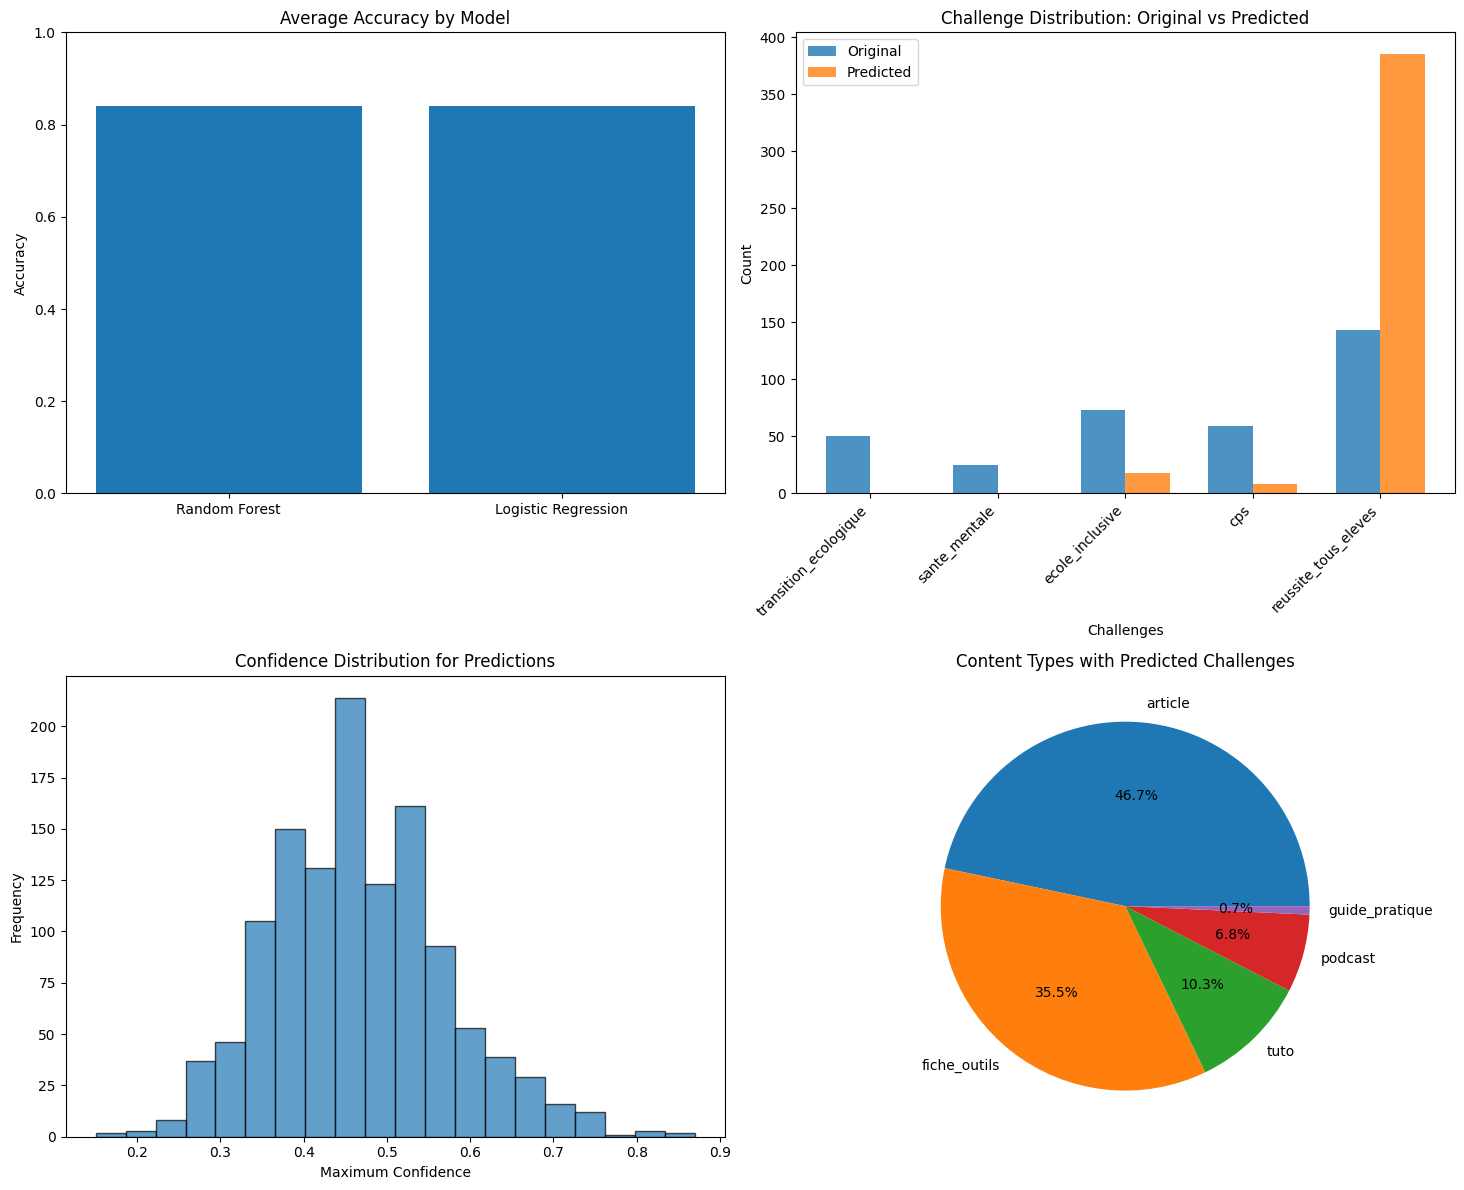

In [16]:
# Create visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model comparison
ax1 = axes[0, 0]
models = ['Random Forest', 'Logistic Regression']
avg_accuracies = [np.mean(rf_accuracy), np.mean(lr_accuracy)]
ax1.bar(models, avg_accuracies)
ax1.set_title('Average Accuracy by Model')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

# 2. Challenge distribution (original + predicted)
ax2 = axes[0, 1]
original_counts = contents_filtered[priority_challenges].sum()
predicted_counts = results_df[[f'{challenge}_prediction' for challenge in priority_challenges]].sum()
predicted_counts.index = priority_challenges

x = np.arange(len(priority_challenges))
width = 0.35
ax2.bar(x - width/2, original_counts, width, label='Original', alpha=0.8)
ax2.bar(x + width/2, predicted_counts, width, label='Predicted', alpha=0.8)
ax2.set_title('Challenge Distribution: Original vs Predicted')
ax2.set_xlabel('Challenges')
ax2.set_ylabel('Count')
ax2.set_xticks(x)
ax2.set_xticklabels(priority_challenges, rotation=45, ha='right')
ax2.legend()

# 3. Confidence distribution
ax3 = axes[1, 0]
ax3.hist(results_df['max_confidence'], bins=20, alpha=0.7, edgecolor='black')
ax3.set_title('Confidence Distribution for Predictions')
ax3.set_xlabel('Maximum Confidence')
ax3.set_ylabel('Frequency')

# 4. Content types in predictions
ax4 = axes[1, 1]
type_counts = results_df[results_df['total_challenges'] > 0]['type'].value_counts()
ax4.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
ax4.set_title('Content Types with Predicted Challenges')

plt.tight_layout()
plt.show()

## Save results

In [17]:
# Save predictions to CSV
results_df.to_csv('predicted_challenges.csv', index=False)
print(f"Results saved to 'predicted_challenges.csv'")

# Save model performance summary
summary_stats = {
    'model': ['Random Forest', 'Logistic Regression'],
    'avg_accuracy': [np.mean(rf_accuracy), np.mean(lr_accuracy)],
    'training_samples': [len(X_train), len(X_train)],
    'test_samples': [len(X_test), len(X_test)],
    'predicted_samples': [len(results_df), len(results_df)]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('model_performance.csv', index=False)
print("Model performance summary saved to 'model_performance.csv'")

print("\nAnalysis completed successfully!")

Results saved to 'predicted_challenges.csv'
Model performance summary saved to 'model_performance.csv'

Analysis completed successfully!
